## logistic regression & random forest

In [31]:
import pandas as pd
import numpy as np

# three classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# cross-validation and performance evaluation
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 1. read training and testing data:

In [32]:
#train = pd.read_csv('../../data/splited/train.csv')
#test = pd.read_csv('../../data/splited/test.csv')
#train_label = train.iloc[:, 1]
#train_features = train.iloc[:, 2 :]
#test_label = test.iloc[:, 1]
#test_features = test.iloc[:, 2 :]

An imbalanced dataset should be split in a stratified manner, i.e. ratios of labels in training and tesing set are identical to the original data set.

In [33]:
data = pd.read_csv('../../data/original/train.csv')

train_features, test_features, train_label, test_label = train_test_split(data.iloc[:, 2 :], data.iloc[:, 1], test_size = 0.2, stratify = data.iloc[:, 1], random_state = 2024)

### 2. resample data

No resampling currently.

### 3. deal with missing values

In [34]:
# replace "-1" with "np.nan"
train_features = train_features.replace(-1, np.nan)
test_features = test_features.replace(-1, np.nan)

In [35]:
# ratio of missing values in train_features
train_features_missing_ratio = train_features.isnull().mean()
train_features_missing_ratio = train_features_missing_ratio[train_features_missing_ratio > 0] # only consider features with non-zero missing ratio
train_features_top_missing_ratio = train_features_missing_ratio.sort_values(ascending=False)
print("missing ratio in train_features:\n")
print(train_features_top_missing_ratio)

missing ratio in train_features:

ps_car_03_cat    0.690587
ps_car_05_cat    0.447329
ps_reg_03        0.180820
ps_car_14        0.071420
ps_car_07_cat    0.019373
ps_ind_05_cat    0.009868
ps_car_09_cat    0.000962
ps_ind_02_cat    0.000380
ps_car_01_cat    0.000181
ps_ind_04_cat    0.000141
ps_car_11        0.000006
ps_car_02_cat    0.000004
ps_car_12        0.000002
dtype: float64


In [36]:
# ratio of missing values in test_features
test_features_missing_ratio = test_features.isnull().mean()
test_features_missing_ratio = test_features_missing_ratio[test_features_missing_ratio > 0] # only consider features with non-zero missing ratio
test_features_top_missing_ratio = test_features_missing_ratio.sort_values(ascending=False)
print("missing ratio in train_features:\n")
print(test_features_top_missing_ratio)

missing ratio in train_features:

ps_car_03_cat    0.692145
ps_car_05_cat    0.449812
ps_reg_03        0.182043
ps_car_14        0.072344
ps_car_07_cat    0.019018
ps_ind_05_cat    0.009324
ps_car_09_cat    0.000932
ps_ind_02_cat    0.000294
ps_car_01_cat    0.000176
ps_ind_04_cat    0.000134
ps_car_02_cat    0.000025
ps_car_11        0.000017
dtype: float64


In [37]:
#columns_to_drop = ['ps_car_03_cat', 'ps_car_05_cat', 'ps_reg_03']
columns_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train_features = train_features.drop(columns=columns_to_drop, errors='ignore') # ignore error if columns to delete don't exist
test_features = test_features.drop(columns=columns_to_drop, errors='ignore')

In [38]:
# names of features with low missing radio
# fill missing values of continuous features with median, fill missing values of categorical/binary features with mode
columns_to_fill_with_mode = ['ps_car_07_cat', 'ps_ind_05_cat', 'ps_car_09_cat',
                             'ps_ind_02_cat', 'ps_car_01_cat', 'ps_ind_04_cat',
                             'ps_car_02_cat']
#columns_to_fill_with_median = ['ps_car_14', 'ps_car_11', 'ps_car_12']
columns_to_fill_with_median = ['ps_car_14', 'ps_car_11', 'ps_car_12', 'ps_reg_03']

# training set
train_features[columns_to_fill_with_mode] = train_features[columns_to_fill_with_mode].fillna(
    train_features[columns_to_fill_with_mode].mode().iloc[0]
)
train_features[columns_to_fill_with_median] = train_features[columns_to_fill_with_median].fillna(
    train_features[columns_to_fill_with_median].median()
)

# testing set
test_features[columns_to_fill_with_mode] = test_features[columns_to_fill_with_mode].fillna(
    test_features[columns_to_fill_with_mode].mode().iloc[0]
)
test_features[columns_to_fill_with_median] = test_features[columns_to_fill_with_median].fillna(
    test_features[columns_to_fill_with_median].median()
)

### 4. standardize the training and testing features:

In [39]:
# names of continuous features
continuous_features = [column_name for column_name in train_features.columns if '_cat' not in column_name and '_bin' not in column_name]
scaler = StandardScaler()
train_continuous = scaler.fit_transform(train_features[continuous_features])
test_continuous = scaler.transform(test_features[continuous_features])

In [40]:
# names of categorical features
categorical_features = [column_name for column_name in train_features.columns if '_cat' in column_name]
encoder = OneHotEncoder(sparse=False)
train_categorical = encoder.fit_transform(train_features[categorical_features])
test_categorical = encoder.transform(test_features[categorical_features])

In [41]:
# names of binary features
binary_features = [column_name for column_name in train_features.columns if '_bin' in column_name]
train_binary = train_features[binary_features].values
test_binary = test_features[binary_features].values

In [42]:
train_features_processed = np.hstack((train_continuous, train_categorical, train_binary))
test_features_processed = np.hstack((test_continuous, test_categorical, test_binary))

In [43]:
train_features_processed.shape, test_features_processed.shape

((476169, 214), (119043, 214))

### 5. train logistic regression & random forest model on the training set:

#### 5.1 logistic regression

Use cross-validation to determine best parameters.

In [44]:
lr_params = {
    'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

lr_random_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=100),
    param_distributions=lr_params,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=2024),
    verbose=2,
    random_state=2025
)

lr_random_search.fit(train_features_processed, train_label)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2024, shuffle=True),
                   estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10.0, 100.0],
                                        'penalty': ['l2'],
                                        'solver': ['lbfgs', 'saga']},
                   random_state=2025, scoring='roc_auc', verbose=2)

In [45]:
lr_random_search.best_params_

{'solver': 'saga', 'penalty': 'l2', 'C': 0.01}

#### 5.2 random forest

Set the parameters to be the parameters in the Medium article.

In [47]:
rf_model = RandomForestClassifier(n_estimators=1200, min_samples_leaf=1000, max_leaf_nodes=100, n_jobs=-1)
rf_model.fit(train_features_processed, train_label)

RandomForestClassifier(max_leaf_nodes=100, min_samples_leaf=1000,
                       n_estimators=1200, n_jobs=-1)

### 6. evaluate the trained model on the testing set based on AUC:

In [46]:
test_label_pred_prob_lr = lr_random_search.best_estimator_.predict_proba(test_features_processed)[:, 1]
auc_score_lr = roc_auc_score(test_label, test_label_pred_prob_lr)
print(f"AUC: {auc_score_lr}")

AUC: 0.6262614007886701


In [48]:
test_label_pred_prob_rf = rf_model.predict_proba(test_features_processed)[:, 1]
auc_score_rf = roc_auc_score(test_label, test_label_pred_prob_rf)
print(f"AUC: {auc_score_rf}")

AUC: 0.6270933024448333


plot ROC curve

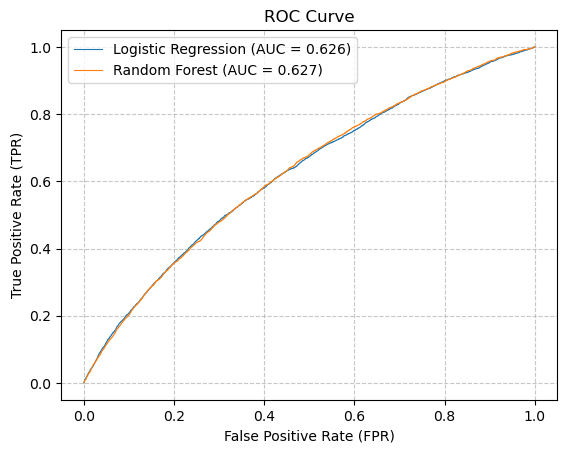

In [49]:
# probability predicted by logistic regression, random forest
test_label_pred_prob_lr = lr_random_search.best_estimator_.predict_proba(test_features_processed)[:, 1]
test_label_pred_prob_rf = rf_model.predict_proba(test_features_processed)[:, 1]

# calculate FPR, TPR and threshold
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_label, test_label_pred_prob_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_label, test_label_pred_prob_rf)

# plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_score_lr:.3f})', linewidth=0.8)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.3f})', linewidth=0.8)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()